In [2]:
import os
import random
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import wandb

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Ссылка на wandb с экспериментами: https://wandb.ai/maximkiselev8376/aaa%20lstm%20experiment?nw=nwusermaximkiselev8376

In [2]:
# логинимся в вандбе
wandb.login(key='37d77515db6a159f86f6c7c987b7dc0eca96f53e')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
RANDOM_SEED = 42

In [4]:
def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
class LSTMWithAttention(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers=1,
        use_bidirectional = False,
        dropout: float = 0.1,
        hidden_fc_size: int = 128
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim // 2,
                           batch_first=True,
                           bidirectional=use_bidirectional,
                           dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_fc_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_fc_size, output_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def attention(self, lstm_output, final_state):
        merged_state = torch.cat([s for s in final_state], 1)
        merged_state = merged_state.squeeze(0).unsqueeze(2)
        weights = torch.bmm(lstm_output, merged_state)
        weights = F.softmax(weights.squeeze(2), dim=1).unsqueeze(2)
        return torch.bmm(torch.transpose(lstm_output, 1, 2), weights).squeeze(2)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedded)

        attn_output = self.attention(output, hidden)

        return self.mlp(attn_output.squeeze(0))

In [6]:
EMPTY_TOKEN = 0
NOT_IN_VOCAB = 1
TARGET_ENCODING = {
    'trebuet_remonta': 0,
    'kosmeticheskii': 1,
    'evro': 2,
    'dizainerskii': 3
}

class CustomDataset(Dataset):
    def __init__(
        self,
        texts: pd.Series,
        targets: pd.Series,
        tokenizer: callable,
        encode_mapping: dict,
        max_tokens_len: int = None
    ):
        self.texts = np.array(texts)
        self.targets = np.array(targets)
        self.max_tokens_len = max_tokens_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        text_tokens = tokenizer(text)
        text_tokens_enc = [encode_mapping.get(token, NOT_IN_VOCAB)
                           for token in text_tokens]
        
        if self.max_tokens_len is not None:
            text_tokens_enc = text_tokens_enc[:self.max_tokens_len] # берем первые `max_tokens_len` токенов

        target = self.targets[idx]
        target = TARGET_ENCODING[target]
        return text_tokens_enc, target

In [7]:
def collate_batch(batch):
    max_tokens_size = 0
    for tokens, target in batch:
        max_tokens_size = max(max_tokens_size, len(tokens))

    tokens_batch = []
    targets_batch = []
    # заполняем пустыми токенами
    for tokens, target in batch:
        tokens_batch.append(
            tokens + [EMPTY_TOKEN] * (max_tokens_size - len(tokens))
        )
        targets_batch.append(target)

    return torch.Tensor(tokens_batch).long(), torch.Tensor(targets_batch).long()

In [8]:
def plot_progress(train_losses, train_roc_aucs, test_loss, test_roc_aucs):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(12)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    
#     Для ограничения графика loss можно пользоваться set_ylim:
    ax1.set_ylim([-0.05, 2])

    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_roc_aucs, label='train accuracy')
    ax2.plot(test_roc_aucs, label='test accuracy')
    ax2.plot(np.ones_like(train_roc_aucs), '--', label='100% accuracy')
    ax2.plot(np.ones_like(train_roc_aucs) * 0.5, '--', label='50% accuracy')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()

In [9]:
def train_model(
    exp_name: str,
    model: nn.Module,
    lr: float  = None,
    epochs: int  = None,
    lr_step: int  = None,
    lr_gamma: float = None,
    train_dataloader: DataLoader = None,
    val_dataloader: DataLoader = None
):
    run = wandb.init(
    project=f"aaa lstm experiment",
    name=exp_name,
    config={
        'model': model.__class__.__name__,
        'lr': lr,
        'epochs': epochs,
        'lr_step': lr_step,
        'lr_gamma': lr_gamma,
        'dataloader_class_name': train_dataloader.__class__.__name__
        }
    )
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer=optimizer,
        step_size=lr_step,
        gamma=lr_gamma,
        last_epoch=-1
    )
    loss = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    best_accuracy = 0

    for epoch in range(epochs):
        for i, (emb_tokens_train, targets_train) in tqdm(enumerate(train_dataloader)):
            model.train()

            emb_tokens_train = emb_tokens_train.to(DEVICE)
            targets_train = targets_train.to(DEVICE)

            optimizer.zero_grad()

            pred_train = model(emb_tokens_train)
            loss_train = loss(pred_train, targets_train)

            loss_train.backward()
            optimizer.step()
            scheduler.step()

            train_losses.append(loss_train.detach().cpu())
            pred_label_train = torch.argmax(pred_train, dim=1)
            train_accuracy.append((pred_label_train == targets_train).detach().cpu().numpy().mean())

            emb_tokens_val, targets_val = next(iter(val_dataloader))
            model.eval()
            with torch.no_grad():
                emb_tokens_val = emb_tokens_val.to(DEVICE)
                targets_val = targets_val.to(DEVICE)

                pred_val = model(emb_tokens_val)
                loss_val = loss(pred_val, targets_val)

                val_losses.append(loss_val.detach().cpu())
                pred_label_val = torch.argmax(pred_val, dim=1)
                val_accuracy.append((pred_label_val == targets_val).detach().cpu().numpy().mean())

                if i % 250 == 0:
                    plot_progress(train_losses, train_accuracy, val_losses, val_accuracy)
                    current_lr = scheduler.optimizer.param_groups[0]['lr']
                    print(f'epoch: {epoch + 1} / {epochs}, lr: {current_lr}')

        
        cur_train_accuracy = np.mean(train_accuracy[-i:])
        cur_train_loss = np.mean(train_losses[-i:])
        cur_val_accuracy = np.mean(val_accuracy[-i:])
        cur_val_loss = np.mean(val_losses[-i:])
        if np.mean(val_accuracy[-i:]) > best_accuracy:
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            best_accuracy = np.mean(val_accuracy[-i:])
            
        wandb.log(
            {'train_accuracy': cur_train_accuracy,
             'train_loss': cur_train_loss,
             'val_accuracy': cur_val_accuracy,
             'val_loss': cur_val_loss}
        )

    print(f'Best accuracy: {best_accuracy}')
    wandb.save('/kaggle/working/best_model.pth')
    wandb.finish()

# Подгружаем данные

In [10]:
df = pd.read_csv('/kaggle/input/final-project-data/data.csv')
df_splitting = pd.read_csv('/kaggle/input/final-project-data/splitting_sample.csv')
df_baseline = pd.read_csv('/kaggle/input/final-project-data/baseline_prediction.csv')
df_tfidf = pd.read_csv('/kaggle/input/final-project-data/tfidf_lr_prediction.csv')

df = df.merge(df_splitting, on='item_id', how='left')
df = df.merge(df_baseline, on='item_id', how='left')
df = df.merge(df_tfidf, on='item_id', how='left')

## Отделяем квартиры от домов

In [11]:
SUBSTRINGS_TO_REPLACE = [',', ' в', ' и', ' га', '-студия', '-студии']
WORDS_TO_DELETE = ['на', 'участке', 'доля', 'аукцион:']
SUBWORD_TO_DELETE = ['м²', 'сот.', '-к'] + [str(i) for i in range(10)]

def clear_description(descr: str):
    for substr in SUBSTRINGS_TO_REPLACE:
        descr = descr.replace(substr, '')
    descr = descr.lower().split(' ')
    result = []

    for word in descr:
        cnt_bad_subwords = 0
        for stop_subwords in SUBWORD_TO_DELETE:
            if stop_subwords in word:
                cnt_bad_subwords += 1
        if (word not in WORDS_TO_DELETE) and (cnt_bad_subwords == 0):
            result.append(word)
    
    return ' '.join(result)


descr_train = df.loc[df['sample_part'] == 'train', 'title'].apply(lambda descr: clear_description(descr))
descr_train.value_counts()

title
квартира            86623
дом                 23645
дача                 4366
коттедж              2194
апартаменты          1792
таунхаус              593
своб. планировка      195
квартире              195
своб. планировке        3
Name: count, dtype: int64

In [12]:
def classification_adv(descr: str):
    clear_desc = clear_description(descr)
    if clear_desc in {'квартира', 'квартире', 'своб. планировка', 'своб. планировке'}:
        return 'квартира'
    elif clear_desc in {'апартаменты'}:
        return 'апартаменты'
    elif clear_desc in {'дом'}:
        return 'дом'
    elif clear_desc in {'дача'}:
        return 'дача'
    elif clear_desc in {'коттедж'}:
        return 'коттедж'
    elif clear_desc in {'таунхаус'}:
        return 'таунхаус'
    
df['object_type'] = df['title'].apply(lambda descr: classification_adv(descr))
df['object_type'].value_counts()

object_type
квартира       145114
дом             39422
дача             7253
коттедж          3605
апартаменты      2980
таунхаус          970
Name: count, dtype: int64

## Создаем словарь

In [13]:
vectorizer = CountVectorizer(
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words=None,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=1.0,
    min_df=10, # ставим ограничение на минимальное количество встреч в корпусе
    max_features=None
)
vectorizer.fit(df.loc[df['sample_part'] == 'train', 'description'])

# создаем токенайзер
tokenizer = vectorizer.build_tokenizer()
# создаем энкодер
encode_mapping = {word: i+2 for i, word in enumerate(vectorizer.vocabulary_)}

## Создаем даталоадер

In [14]:
train_dataset = CustomDataset(
    texts=df.loc[df['sample_part'] == 'train', 'description'],
    targets=df.loc[df['sample_part'] == 'train', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping
)
val_dataset = CustomDataset(
    texts=df.loc[df['sample_part'] == 'val', 'description'],
    targets=df.loc[df['sample_part'] == 'val', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping
)
test_dataset = CustomDataset(
    texts=df.loc[df['sample_part'] == 'test', 'description'],
    targets=df.loc[df['sample_part'] == 'test', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_batch)

# LSTM с attention pooling

## Без scheduler

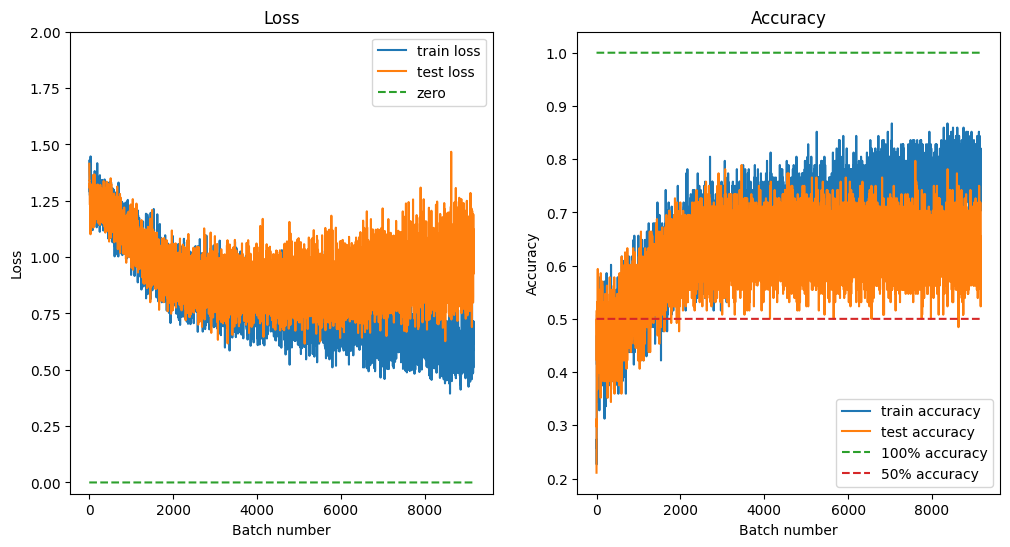

754it [00:45,  6.67it/s]

epoch: 10 / 10, lr: 0.0005


935it [00:55, 16.99it/s]
wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Best accuracy: 0.6433100240899358


train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▅▇██████▇
val_loss,█▄▂▁▁▁▁▂▃▄
train_accuracy,0.76915
train_loss,0.59923
val_accuracy,0.63111
val_loss,0.98463


In [16]:
set_seed(RANDOM_SEED)

model = LSTMWithAttention(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=128,
    hidden_dim=128,
    output_dim=4,
    n_layers=2,
    use_bidirectional=True,
    dropout=0.2,
    hidden_fc_size=64
).to(DEVICE)

train_model(exp_name='2 layers without sceduler', model=model, lr=0.0005, epochs=10, lr_step=1e9, lr_gamma=1, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

## Со scheduler

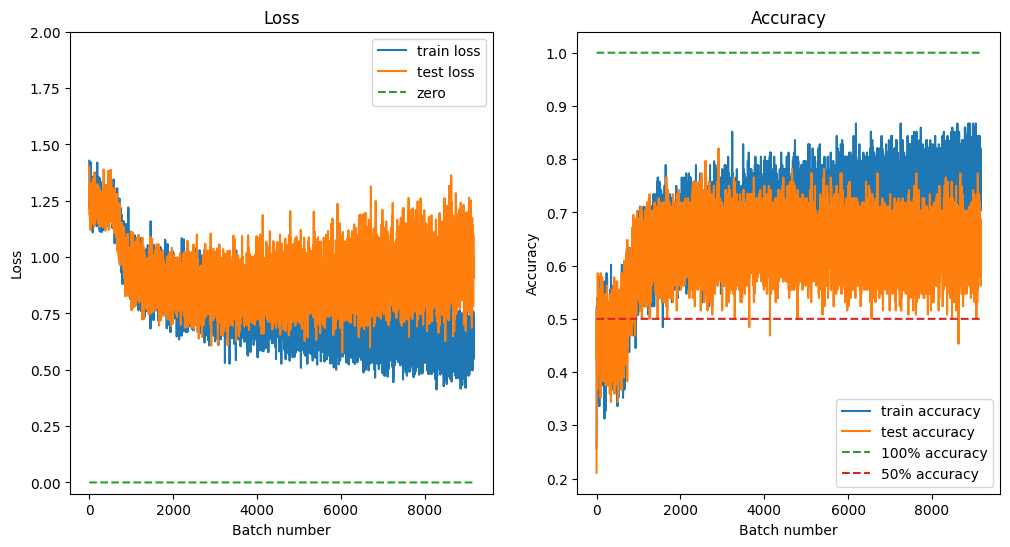

754it [00:45,  5.51it/s]

epoch: 10 / 10, lr: 0.00015906436205108607


935it [00:55, 16.91it/s]


Best accuracy: 0.6492739561027837


train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▇██████▇▇
val_loss,█▂▁▁▁▂▂▃▃▄
train_accuracy,0.77274
train_loss,0.60482
val_accuracy,0.63321
val_loss,0.96851


In [17]:
set_seed(RANDOM_SEED)

model = LSTMWithAttention(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=128,
    hidden_dim=128,
    output_dim=4,
    n_layers=2,
    use_bidirectional=True,
    dropout=0.2,
    hidden_fc_size=64
).to(DEVICE)

train_model(exp_name='2 layers with scheduler', model=model, lr=0.001, epochs=10, lr_step=100, lr_gamma=0.98, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

## Шатаем параметры

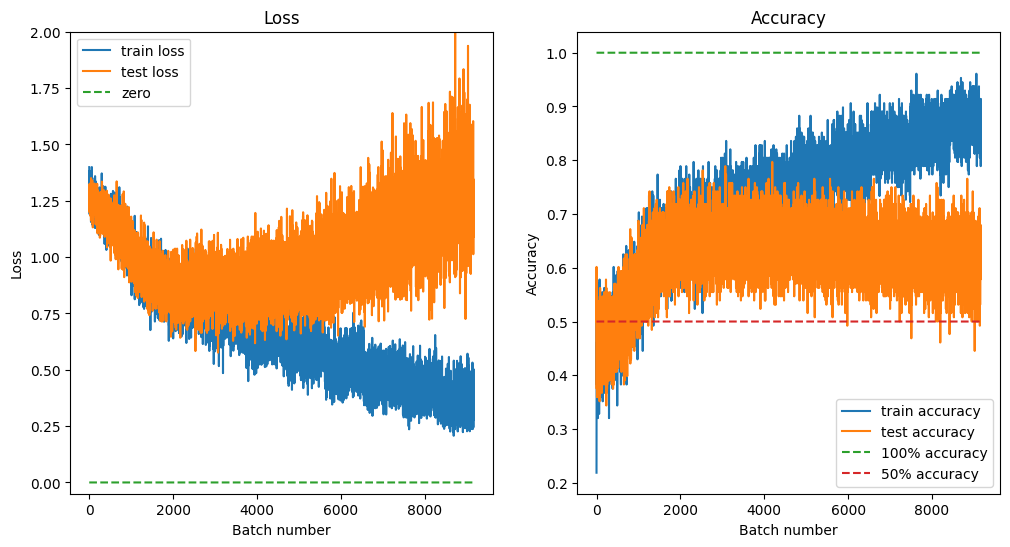

753it [01:16,  5.45it/s]

epoch: 10 / 10, lr: 0.00015906436205108607


935it [01:35,  9.81it/s]


Best accuracy: 0.6495332574946466


train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▆████▇▇▇▇
val_loss,▆▂▁▁▁▂▃▅▆█
train_accuracy,0.87241
train_loss,0.35862
val_accuracy,0.61912
val_loss,1.29039


In [18]:
set_seed(RANDOM_SEED)

model = LSTMWithAttention(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=256,
    hidden_dim=256,
    output_dim=4,
    n_layers=1,
    use_bidirectional=True,
    dropout=0.1,
    hidden_fc_size=32
).to(DEVICE)

train_model(exp_name='1 layers with scheduler and other params', model=model, lr=0.001, epochs=10, lr_step=100, lr_gamma=0.98, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

## Возьмем lr поменьше и увеличим dropout

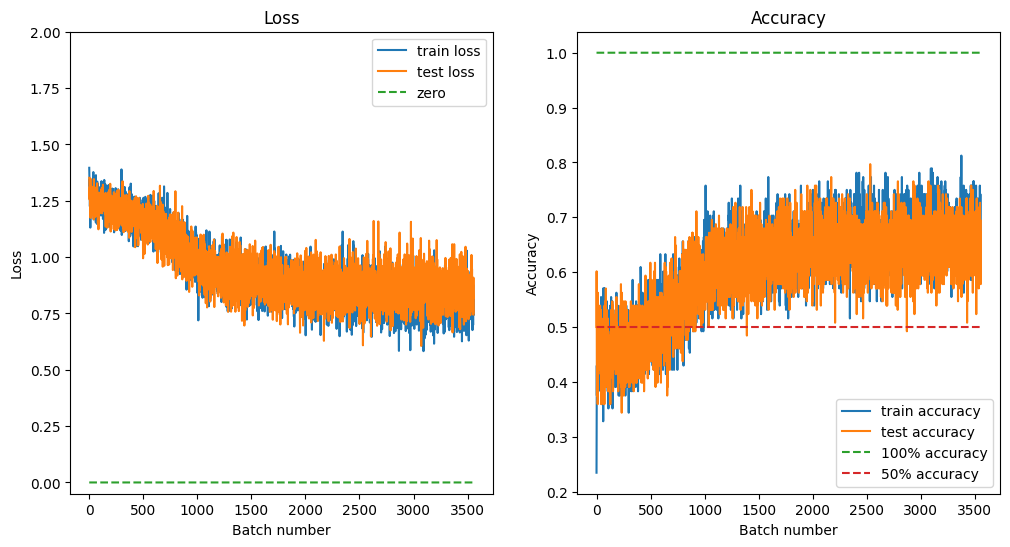

752it [01:17,  4.90it/s]

epoch: 4 / 10, lr: 0.0001721792071521107


884it [01:30, 10.15it/s]

In [ ]:
set_seed(RANDOM_SEED)

model = LSTMWithAttention(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=256,
    hidden_dim=256,
    output_dim=4,
    n_layers=1,
    use_bidirectional=True,
    dropout=0.25,
    hidden_fc_size=32
).to(DEVICE)

train_model(exp_name='1 layers with scheduler reduce lr, increase dropout', model=model, lr=0.0005, epochs=10, lr_step=100, lr_gamma=0.97, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

# Попробуем взять больше слоев

In [ ]:
set_seed(RANDOM_SEED)

model = LSTMWithAttention(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=256,
    hidden_dim=256,
    output_dim=4,
    n_layers=3,
    use_bidirectional=True,
    dropout=0.25,
    hidden_fc_size=32
).to(DEVICE)

train_model('3 layers with scheduler', model=model, lr=0.0005, epochs=10, lr_step=100, lr_gamma=0.97, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

**Итог:** архитектура позволяет выбить точность `0.65`. Это лучше чем baseline, но хуже, чем давал TF-IDF

## Пробую ограничить максимальное количество токенов во входной последовательности
**Мотивация**: сейчас большинство токенов во входной последовательности модели – нули (символ пустого токена). Это может негативно влиять на результат работы модели. Поэтому я попробую сократить максимальную длину последовательности

In [17]:
item_lens = []

for item in tqdm(train_dataset):
    item_lens.append(len(item[0]))

100%|██████████| 119606/119606 [00:09<00:00, 12817.70it/s]


In [18]:
print('Среднее:', np.mean(item_lens))
print('90 персентиль:', np.percentile(item_lens, 90))
print('95 персентиль:', np.percentile(item_lens, 95))
print('99 персентиль:', np.percentile(item_lens, 99))

Среднее: 80.21992207748775
90 персентиль: 162.0
95 персентиль: 201.0
99 персентиль: 301.0


Возьмем 95 персентиль

In [19]:
# переопределяем даталоадер
train_dataset_clip = CustomDataset(
    texts=df.loc[df['sample_part'] == 'train', 'description'],
    targets=df.loc[df['sample_part'] == 'train', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping,
    max_tokens_len=200
)
val_dataset_clip = CustomDataset(
    texts=df.loc[df['sample_part'] == 'val', 'description'],
    targets=df.loc[df['sample_part'] == 'val', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping,
    max_tokens_len=200
)
test_dataset_clip = CustomDataset(
    texts=df.loc[df['sample_part'] == 'test', 'description'],
    targets=df.loc[df['sample_part'] == 'test', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping,
    max_tokens_len=200
)

train_dataloader_clip = DataLoader(train_dataset_clip, batch_size=128, shuffle=True, collate_fn=collate_batch)
val_dataloader_clip = DataLoader(val_dataset_clip, batch_size=128, shuffle=True, collate_fn=collate_batch)
test_dataloader_clip = DataLoader(test_dataset_clip, batch_size=128, shuffle=False, collate_fn=collate_batch)

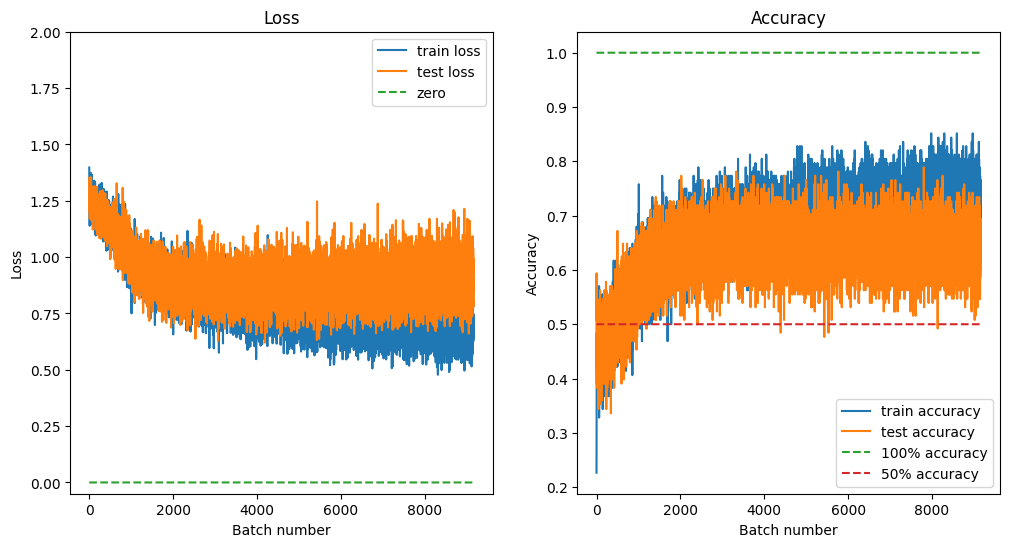

753it [00:57,  5.71it/s]

epoch: 10 / 10, lr: 3.127503630906812e-05


935it [01:10, 13.31it/s]
wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Best accuracy: 0.646948608137045


train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▆████████
val_loss,█▃▁▁▁▁▁▁▂▂
train_accuracy,0.73934
train_loss,0.67694
val_accuracy,0.64274
val_loss,0.90235


In [21]:
set_seed(RANDOM_SEED)

model = LSTMWithAttention(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=256,
    hidden_dim=256,
    output_dim=4,
    n_layers=1,
    use_bidirectional=True,
    dropout=0.25,
    hidden_fc_size=32
).to(DEVICE)

train_model(exp_name='1 layer with scheduler with clip sent', model=model, lr=0.0005, epochs=10, lr_step=100, lr_gamma=0.97, train_dataloader=train_dataloader_clip, val_dataloader=val_dataloader_clip)

In [22]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

val_accuracy = []

model.eval()
with torch.no_grad():
    for emb_tokens_val, targets_val in tqdm(val_dataloader_clip):
        emb_tokens_val = emb_tokens_val.to(DEVICE)
        targets_val = targets_val.to(DEVICE)

        pred_val = model(emb_tokens_val)
        pred_label_val = torch.argmax(pred_val, dim=1)
        val_accuracy.append((pred_label_val == targets_val).detach().cpu().numpy().mean())
np.mean(val_accuracy)

100%|██████████| 234/234 [00:05<00:00, 40.54it/s]


0.6471157270436118

**Итог**: Большого влияния на качество нет

# Немного изменим архитектуру

Теперь вместо attention-пулинга по выходу lstm будем брать вектор скрытого состояния

In [15]:
class LSTMNet(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers=1,
        use_bidirectional = False,
        dropout: float = 0.1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim // 2,
                           batch_first=True,
                           bidirectional=use_bidirectional,
                           dropout=dropout)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedded)

        merged_state = torch.cat([s for s in hidden], 1)
        merged_state = self.dropout(merged_state)
        
        return self.fc(merged_state)

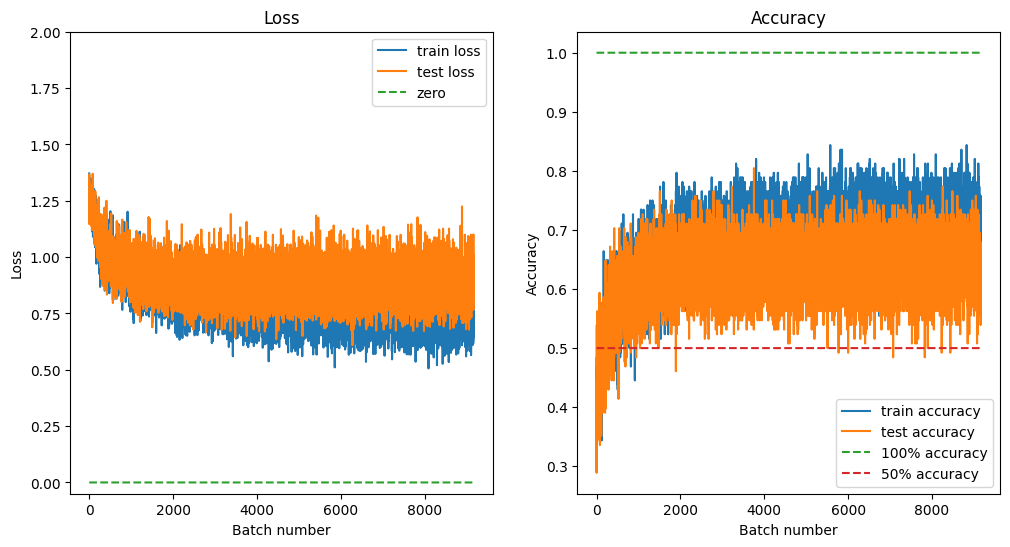

753it [00:46,  7.23it/s]

epoch: 10 / 10, lr: 3.7951362369980916e-06


935it [00:56, 16.41it/s]
wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Best accuracy: 0.6399223768736617


train_accuracy,▁▅▆▇▇█████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▆████████
val_loss,█▃▁▁▁▁▁▁▁▁
train_accuracy,0.71176
train_loss,0.73663
val_accuracy,0.6378
val_loss,0.89148


In [16]:
set_seed(RANDOM_SEED)

model = LSTMNet(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=256,
    hidden_dim=128,
    output_dim=4,
    n_layers=1,
    use_bidirectional=True,
    dropout=0.1
).to(DEVICE)

train_model(exp_name='LSTMNet (wo attention) 1 layer', model=model, lr=0.001, epochs=10, lr_step=50, lr_gamma=0.97, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Качество +- такое же, даже чуть хуже

Попробуем увеличить дропаут и скорость обучения

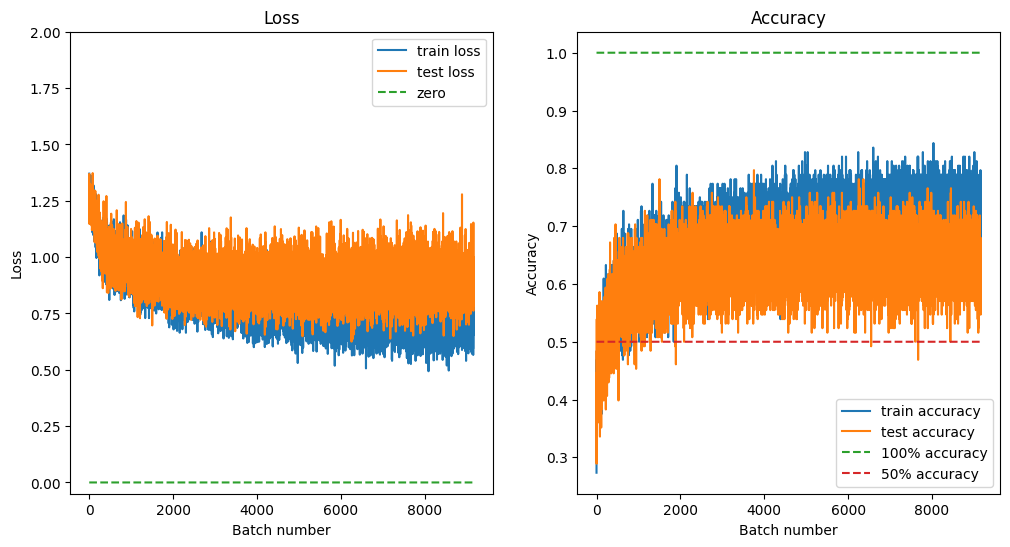

753it [00:46,  7.27it/s]

epoch: 10 / 10, lr: 2.479544184922461e-05


935it [00:56, 16.43it/s]


Best accuracy: 0.6409763115631691


train_accuracy,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▃▁▁▁▁▁▁▂▂
train_accuracy,0.72495
train_loss,0.71491
val_accuracy,0.63823
val_loss,0.90263


In [17]:
set_seed(RANDOM_SEED)

model = LSTMNet(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=256,
    hidden_dim=128,
    output_dim=4,
    n_layers=1,
    use_bidirectional=True,
    dropout=0.3
).to(DEVICE)

train_model(exp_name='LSTMNet (wo attention) 1 layer | increase dropout and lr', model=model, lr=0.001, epochs=10, lr_step=50, lr_gamma=0.98, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Качество +- такое же, как было

**Итог по архитектуре**: получается выбить точность `0.64`. В случае lstm + attention было `0.65`

# Пробую примешать тип недвижимости к LSTM с attention

In [15]:
EMPTY_TOKEN = 0
NOT_IN_VOCAB = 1
TARGET_ENCODING = {
    'trebuet_remonta': 0,
    'kosmeticheskii': 1,
    'evro': 2,
    'dizainerskii': 3
}
OBJ_TYPE_MAPPING = {
    'квартира': 0,
    'дом': 1,
    'дача': 2,
    'коттедж': 3,
    'апартаменты': 4,
    'таунхаус': 5
}


class CustomDatasetWithObjType(Dataset):
    def __init__(
        self,
        texts: pd.Series,
        obj_types: pd.Series,
        targets: pd.Series,
        tokenizer: callable,
        encode_mapping: dict
    ):
        self.texts = np.array(texts)
        self.obj_types = np.array(obj_types)
        self.targets = np.array(targets)
        
        self.tokenizer = tokenizer
        self.encode_mapping = encode_mapping
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        text_tokens = self.tokenizer(text)
        text_tokens_enc = [self.encode_mapping.get(token, NOT_IN_VOCAB)
                           for token in text_tokens]
        
        obj_type_idx = OBJ_TYPE_MAPPING[self.obj_types[idx]]
        # one hot encoding transform
        obj_type = np.zeros(len(OBJ_TYPE_MAPPING))
        obj_type[obj_type_idx] = 1.0

        target = self.targets[idx]
        target = TARGET_ENCODING[target]

        return {'descr': text_tokens_enc, 'obj_type': obj_type}, target

In [16]:
def collate_batch_with_obj_type(batch):
    max_tokens_size = 0
    for data, target in batch:
        tokens = data['descr']
        max_tokens_size = max(max_tokens_size, len(tokens))

    tokens_batch = []
    obj_type_batch = []
    targets_batch = []
    # заполняем пустыми токенами
    for data, target in batch:
        tokens, obj_type = data['descr'], data['obj_type']
        tokens_batch.append(
            tokens + [EMPTY_TOKEN] * (max_tokens_size - len(tokens))
        )
        obj_type_batch.append(obj_type)
        targets_batch.append(target)

    return ({'descr': torch.Tensor(tokens_batch).long(), 'obj_type': torch.Tensor(obj_type_batch).float()},
            torch.Tensor(targets_batch).long())

In [17]:
class LSTMWithAttentionAndObjType(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers=1,
        use_bidirectional = False,
        dropout: float = 0.1,
        hidden_fc_size: int = 128
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim // 2,
                           batch_first=True,
                           bidirectional=use_bidirectional,
                           dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + len(OBJ_TYPE_MAPPING), hidden_fc_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_fc_size, output_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def attention(self, lstm_output, final_state):
        merged_state = torch.cat([s for s in final_state], 1)
        merged_state = merged_state.squeeze(0).unsqueeze(2)
        weights = torch.bmm(lstm_output, merged_state)
        weights = F.softmax(weights.squeeze(2), dim=1).unsqueeze(2)
        return torch.bmm(torch.transpose(lstm_output, 1, 2), weights).squeeze(2)

    def forward(self, descr, object_type_one_hot):
        embedded = self.embedding(descr)
        output, (hidden, cell) = self.rnn(embedded)

        attn_output = self.attention(output, hidden)

        output = torch.cat([object_type_one_hot, attn_output.squeeze(0)], dim=1)
        return self.mlp(output)

In [18]:
def train_model_with_obj_type(
    exp_name: str,
    model: nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    lr: float = None,
    epochs: int = None,
    lr_step: int = None,
    lr_gamma: float = None
):
    run = wandb.init(
    project=f"aaa lstm experiment",
    name=exp_name,
    config={
        'model': model.__class__.__name__,
        'lr': lr,
        'epochs': epochs,
        'lr_step': lr_step,
        'lr_gamma': lr_gamma,
        'dataloader_class_name': train_dataloader.__class__.__name__
        }
    )
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer=optimizer,
        step_size=lr_step,
        gamma=lr_gamma,
        last_epoch=-1
    )
    loss = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    best_accuracy = 0

    for epoch in range(epochs):
        for i, (data_train, targets_train) in tqdm(enumerate(train_dataloader)):
            model.train()
            
            emb_tokens_train, object_type_one_hot = data_train['descr'], data_train['obj_type']
            object_type_one_hot_train = object_type_one_hot.to(DEVICE)
            emb_tokens_train = emb_tokens_train.to(DEVICE)
            targets_train = targets_train.to(DEVICE)

            optimizer.zero_grad()

            pred_train = model(emb_tokens_train, object_type_one_hot_train)
            loss_train = loss(pred_train, targets_train)

            loss_train.backward()
            optimizer.step()
            scheduler.step()

            train_losses.append(loss_train.detach().cpu())
            pred_label_train = torch.argmax(pred_train, dim=1)
            train_accuracy.append((pred_label_train == targets_train).detach().cpu().numpy().mean())

            data_val, targets_val = next(iter(val_dataloader))
            model.eval()
            with torch.no_grad():
                emb_tokens_val, object_type_one_hot_val = data_val['descr'], data_val['obj_type']
    
                emb_tokens_val = emb_tokens_val.to(DEVICE)
                object_type_one_hot_val = object_type_one_hot_val.to(DEVICE)
                targets_val = targets_val.to(DEVICE)

                pred_val = model(emb_tokens_val, object_type_one_hot_val)
                loss_val = loss(pred_val, targets_val)

                val_losses.append(loss_val.detach().cpu())
                pred_label_val = torch.argmax(pred_val, dim=1)
                val_accuracy.append((pred_label_val == targets_val).detach().cpu().numpy().mean())

                if i % 250 == 0:
                    plot_progress(train_losses, train_accuracy, val_losses, val_accuracy)
                    current_lr = scheduler.optimizer.param_groups[0]['lr']
                    print(f'epoch: {epoch + 1} / {epochs}, lr: {current_lr}')

        cur_train_accuracy = np.mean(train_accuracy[-i:])
        cur_train_loss = np.mean(train_losses[-i:])
        cur_val_accuracy = np.mean(val_accuracy[-i:])
        cur_val_loss = np.mean(val_losses[-i:])
        if np.mean(val_accuracy[-i:]) > best_accuracy:
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            best_accuracy = np.mean(val_accuracy[-i:])

    wandb.log(
            {'train_accuracy': cur_train_accuracy,
             'train_loss': cur_train_loss,
             'val_accuracy': cur_val_accuracy,
             'val_loss': cur_val_loss}
        )

    print(f'Best accuracy: {best_accuracy}')
    wandb.save('/kaggle/working/best_model.pth')
    wandb.finish()

## Создаю даталоадеры

In [19]:
train_dataset_with_obj_type = CustomDatasetWithObjType(
    texts=df.loc[df['sample_part'] == 'train', 'description'],
    obj_types=df.loc[df['sample_part'] == 'train', 'object_type'],
    targets=df.loc[df['sample_part'] == 'train', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping
)
val_dataset_with_obj_type = CustomDatasetWithObjType(
    texts=df.loc[df['sample_part'] == 'val', 'description'],
    obj_types=df.loc[df['sample_part'] == 'val', 'object_type'],
    targets=df.loc[df['sample_part'] == 'val', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping
)
test_dataset_with_obj_type = CustomDatasetWithObjType(
    texts=df.loc[df['sample_part'] == 'test', 'description'],
    obj_types=df.loc[df['sample_part'] == 'test', 'object_type'],
    targets=df.loc[df['sample_part'] == 'test', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping
)

train_dataloader_with_obj_type = DataLoader(train_dataset_with_obj_type, batch_size=128, shuffle=True, collate_fn=collate_batch_with_obj_type)
val_dataloader_with_obj_type = DataLoader(val_dataset_with_obj_type, batch_size=128, shuffle=True, collate_fn=collate_batch_with_obj_type)
test_dataloader_with_obj_type = DataLoader(test_dataset_with_obj_type, batch_size=128, shuffle=False, collate_fn=collate_batch_with_obj_type)

## Запускаю обучение

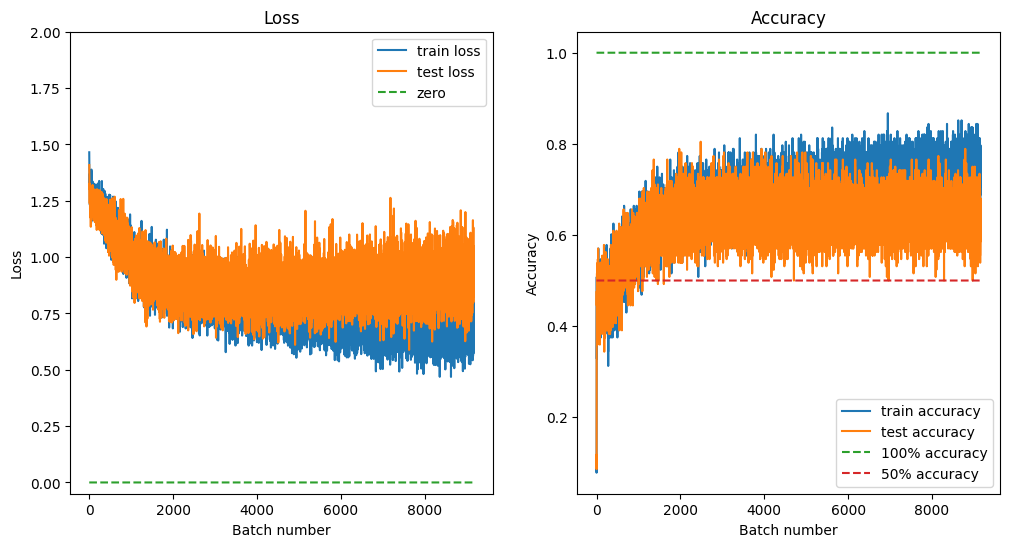

752it [01:22,  3.65it/s]

epoch: 10 / 10, lr: 3.127503630906812e-05


935it [01:41,  9.21it/s]
wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Best accuracy: 0.6479607200214133


train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.742
train_loss,0.67055
val_accuracy,0.6443
val_loss,0.89732


In [20]:
set_seed(RANDOM_SEED)

model = LSTMWithAttentionAndObjType(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=256,
    hidden_dim=256,
    output_dim=4,
    n_layers=1,
    use_bidirectional=True,
    dropout=0.25,
    hidden_fc_size=32
).to(DEVICE)

train_model_with_obj_type(
            exp_name='LSTMWithAttentionAndObjType 1 layer',
            model=model,
            train_dataloader=train_dataloader_with_obj_type,
            val_dataloader=val_dataloader_with_obj_type,
            lr=0.0005,
            epochs=10,
            lr_step=100,
            lr_gamma=0.97)

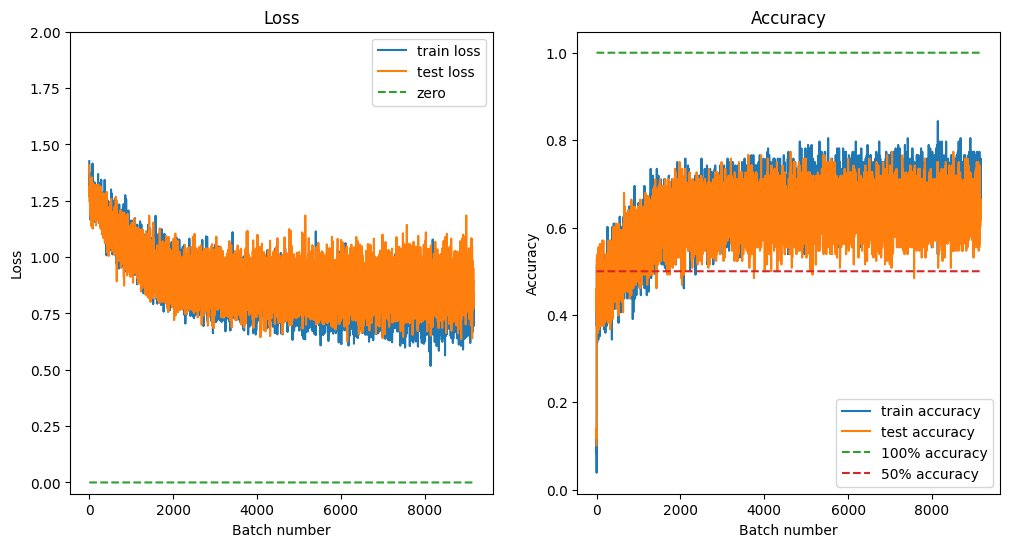

754it [00:49,  6.41it/s]

epoch: 10 / 10, lr: 3.127503630906812e-05


935it [01:00, 15.35it/s]


Best accuracy: 0.6417374866167024


train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.68994
train_loss,0.77683
val_accuracy,0.64174
val_loss,0.86735


In [21]:
set_seed(RANDOM_SEED)

model = LSTMWithAttentionAndObjType(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=128, # уменьшаем размерность
    hidden_dim=128, # уменьшаем размерность
    output_dim=4,
    n_layers=2, # увеличиваем число слоев
    use_bidirectional=True,
    dropout=0.25,
    hidden_fc_size=32
).to(DEVICE)

train_model_with_obj_type(
            exp_name='LSTMWithAttentionAndObjType 2 layers other params',
            model=model,
            train_dataloader=train_dataloader_with_obj_type,
            val_dataloader=val_dataloader_with_obj_type,
            lr=0.0005,
            epochs=10,
            lr_step=100,
            lr_gamma=0.97)

**Итог**: Добавок в качестве нет(

# Смотрим где lstm больше всего ошибалась

In [30]:
api = wandb.Api()
run = api.run('maximkiselev8376/aaa lstm experiment/66uf2dnf') # берем лучшую модель (выбирал по графикам wand)
for file in run.files():
    if 'best_model.pth' in str(file):
        file.download()

In [32]:
# загружаем веса модели
set_seed(RANDOM_SEED)

model = LSTMWithAttention(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=256,
    hidden_dim=256,
    output_dim=4,
    n_layers=1,
    use_bidirectional=True,
    dropout=0.25,
    hidden_fc_size=32
).to(DEVICE)

model.load_state_dict(torch.load('/kaggle/working/working/best_model.pth'))

Random seed set as 42


<All keys matched successfully>

In [33]:
val_accuracy = []

model.eval()
with torch.no_grad():
    for emb_tokens_val, targets_val in tqdm(val_dataloader):
        emb_tokens_val = emb_tokens_val.to(DEVICE)
        targets_val = targets_val.to(DEVICE)

        pred_val = model(emb_tokens_val)
        pred_label_val = torch.argmax(pred_val, dim=1)
        val_accuracy.append((pred_label_val == targets_val).detach().cpu().numpy().mean())
np.mean(val_accuracy)

100%|██████████| 234/234 [00:08<00:00, 28.05it/s]


0.6525980029585798

In [34]:
test_preds = []
test_targets = []

model.eval()
with torch.no_grad():
    for emb_tokens_test, targets_test in tqdm(test_dataloader):
        emb_tokens_test = emb_tokens_test.to(DEVICE)
        targets_test = targets_test.to(DEVICE)

        pred_test = model(emb_tokens_test)
        pred_label_test = torch.argmax(pred_test, dim=1)
        
        test_preds.append(pred_label_test.detach().cpu().tolist())
        test_targets.append(targets_test.detach().cpu().tolist())

test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

100%|██████████| 390/390 [00:13<00:00, 27.97it/s]


Смотрим, где модель ошибается

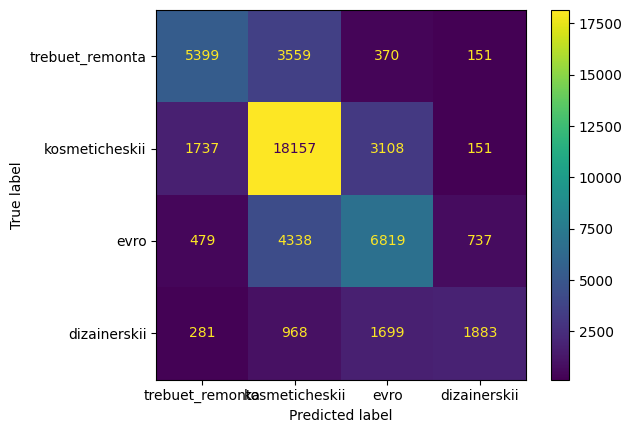

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_targets, test_preds, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(TARGET_ENCODING.keys()))
disp.plot()

In [36]:
test_descriptions = df.loc[df['sample_part'] == 'test', 'description'].values

# Смотрим примеры, где модель ошибается

## требует ремонта – косметический

In [37]:
# true label = требует ремонта, ответ модели: косметический
mask = (test_targets != test_preds) & (test_targets == 0) & (test_preds == 1)

for desc in test_descriptions[mask][:5]:
    print(desc, end='\n\n')

Собственник без комиссий, залог 70000 (можно разбить на 2 мес). До метро Яхромская 2 минуты пешком. Уважаемые Агенты звонить только в том случае если у Вас есть реальный клиент. Кто ищет по дешевле тоже просьба не беспокоить, строго без торга. 
Рассматриваются только граждане РФ, предпочтение семейной паре.
Квартира сдается на длительный срок. 
Современный монолитный дом (свечка 25 этажей) 2009г постройки, чистый подъезд с консьержем. Комнаты изолированные 19 и 12.5 кв/м, кухня 10.5 кв/м, коридор 9 кв/м, тамбур 5 кв/м, лоджия застеклена 3 кв/м. Окна пластиковые во двор, отличный Панорамный вид, муниципальный ремонт. Кондиционер в большой комнате, 2 металлических двери. 
Из мебели: 
Кухонный гарнитур, духовой шкаф, варочная панель, холодильник, кухонный стол.
В спальне двухспальная кровать и мини комод. Большая комната - мини открытая стенка. В коридорах шкаф купе и шкаф для одежды. 
70000р/мес строго без торга + Вода по счетчикам + Электричество (2000р-3500р в зависимости от расхода).


Довольно неочевидные описания для классификации – в них не содержится информации о ремонте / информация не совпадает с таргетом. Понятно почему модель не может правильно на них ответить

In [38]:
# true label = косметический, ответ модели: требует ремонта
mask = (test_targets != test_preds) & (test_targets == 1) & (test_preds == 0)

for desc in test_descriptions[mask][:5]:
    print(desc, end='\n\n')

Продается дом, 
Общая площадь 497м², жилая 242м², 2 этажа + цокольный.
Газ, вода, канализация.
Участок 12 соток в собственности. Дом расположен в 10 км от г. Мин Воды, до Пятигорска 15 км, Железноводска 10 км.
На территории поселка санаторий с новотерской целебной водой.
Школа, Дом Культуры, церковь в 10-15 минутах ходьбы от дома.
Жилой только первый этаж, в цокольном этаже гараж, баня, бойлерная.
Торг возможен.

Светлая, уютная, просторная  квартира с прозрачной юридической историей.Отличная планировка (распашонка с двумя лоджиями) и  удачное расположение  дома (2 минуты от метро) не разочарует владельца в правильности приобретения.В квартире сделана электропроводка, установлены новые радиаторы и остекление. Ухоженный дом, чистый подъезд, благоустройнный двор, достойное окружение. В непосредственной близости вся необходимая инфраструктура: детские сады, школы, центры доп. образования, центры развлечений и занятий спортом, парк. Реальная альтернатива, оперативный показ, быстрый выход н

Снова неочевидные описания – из них нельзя сделать правильный вывод о ремонте

## косметический – евро

In [39]:
# true label = косметический, ответ модели: евро
mask = (test_targets != test_preds) & (test_targets == 1) & (test_preds == 2)

for desc in test_descriptions[mask][:5]:
    print(desc, end='\n\n')

Продам полуособняк в центре города (ул.Клыкова около гор. отдела) площадью 70 кв. м. В доме три просторные комнаты, все удобоства, центральная канализация. Установлена новая газовая колонка, сплит-система. Недавно сделан хороший ремонт, заменена сантехника, установлены качественные пластиковые окна. Возможна продажа с мебелью и бытовой техникой (по договоренности). Также имеется небольшой асфальтированный двор, огороженный металическим забором. Показ до 16.00

Сдам 4 -комнатную благоустроенную квартиру на длительный срок.
В гостиной-кухне-столовой (40 кв.м) есть всё для комфортабельного отдыха, включая посудомоечную машину. Вид из окон на горы.
Три спальни- 15, 13,5 и 12 кв.м. Вид из окон на парк и море.
Два сан. узла и два открытых балкона.
Пешком до моря 30 минут через парковую зону.

Продается трехкомнатная светлая уютная квартира на шестом этаже семнадцати этажного дом в Кировском районе. Общая площадь 72 м2. Окна пластиковые выходят на обе стороны. Две лоджии. В квартире сделан ка

In [41]:
# true label = евро, ответ модели: косметический
mask = (test_targets != test_preds) & (test_targets == 2) & (test_preds == 1)

for desc in test_descriptions[mask][:5]:
    print(desc, end='\n\n')

Продаю уютную, тёплую квартиру. Рядом детская поликлиника,  школа, парки, детский сад, ФОК, магазины, остановки. Тихий двор. В доме ТСЖ, низкие платежи. В доме заменены все стояки. В квартире выравнены все стены, залит пол.  Вам останется поменять обои под свой вкус. В данный момент квартира сдаётся. 
В УСЛУГАХ РИЭЛТОРА НЕ НУЖДАЮСЬ!!!

Объявление от собственника - без комиссии. Просьба агентам не звонить Сдается уютная ,просторная квартира на длительный срок. есть все для проживание (мебель,техника ). Имеется инфраструктура, школа, детский сад. Сдаем приличным жильцам.

Залог 45000. Коммунальные платежи включены (без счётчиков)

СНТ ЛЮБИТЕЛЬ-2 Проспект Победы 295 центр северо-запада,участок на центральной улице,рядом с проходной Победы ,все строения и Земля оформлены и в собственности документы на руках,огорожен профлистом , гараж 10 на 12 шлакоблок кирпич облицовочный,домик 10 на 5 облицованный кирпич ,баня 6 на 5 облицованный кирпич комната отдыха вагонка сосна ,мойка парилка осина п

В этих примерах также тяжело найти различия между косметическим и евро ремонтом

## евро – дизайнерский

In [44]:
# true label = дизайнерский, ответ модели: евро
mask = (test_targets != test_preds) & (test_targets == 3) & (test_preds == 2)

for desc in test_descriptions[mask][:5]:
    print(desc, end='\n\n')

Дом  10*12.180 квадратов+цокольный этаж 5*8 высота 2 метра Участок 8 соток правильной формы,ровный сухой, на участке баня 6*7 , имеется беседка, гараж, газифицирован,  2 км до города,строили сами и проживаем круглый год. Все качественно и без вложений. Газифицирован , дорога чиститься , комуналка копейки . СОБСТВЕННИК.Полностью укомплектован. Остаётся практически все .Обмен рассматривается на ликвидную недвижимость.

Продам Дом в Сочи, Центральный район, Современный доходный дом площадью 1210 кв. м2. (Собственность с 2013 г.) начало Санаторной /ул. Калужская ( семь минут от поворота с ул. Виноградная) в сторону моря идти пешком 20 мин. До Центра Морпорта 10 минут езды.. Собственная закрытая территория. Удача 3 в одном : Земля в Собственности + Дом в Собственности + Готовый Бизнес с большим доходом в месяц! Участок 15 соток (Собственность). Собственная ТП с мощностью 50 кВт. Городская канализация и водопровод. Подключен полностью Газ. Все законно. В эксплуатацию сдан по всем нормативам.

## косметический – дизайнерский

In [45]:
# true label = дизайнерский, ответ модели: косметический
mask = (test_targets != test_preds) & (test_targets == 3) & (test_preds == 1)

for desc in test_descriptions[mask][:5]:
    print(desc, end='\n\n')

"Под ключ дача-усадьба" Жилой 2-х этажный дом на кирпичном фундаменте с двумя подполами. В доме русская печь, встроенный камин, отделаный чугуном. 4 комнаты, кухня, столовая, веранда. Пристроеный хозяйственный двор. На участке баня (с подводкой воды из колодца), собственный колодец (16 бетонных колец), беседка с подполом, кирпичная крытая площадка под мангал. Земля плодородная. Плодовые деревья и кустарники. В деревне расположен пожарный пруд - можно купаться и ловить рыбу, лес сразу за околицей.

Сдам светлую, тёплую, уютную квартиру. Расположена рядом с Машиностроительным техникумом, дворцом пионеров. В шаговой доступности остановка общественного транспорта, магазины. В квартире есть: диван, кровать, шифоньер, кухонный гарнитур, эл.плита, стиральная машина. Балкон застеклён. Оплата 24т.р (комунальные платежи включены) + залог 12т.р.

ОТДЕЛЬНОСТОЯЩИЙ.51.2 кв.м.метров. -УЗАКОНЕННЫХ!комната 12,3 кв.м., комната 18 кв.м.,сан.узел 7.5 кв.м.в данный момент 38 кв.м.жилой площади.межевание  е

Тут тоже неочевидные описания

## **Итоги:**
Модель +- адекватно предсказывает метки. Если есть ошибки, то это ошибки +- 1 уровень (например, вместо евро предсказываем косметический или дизайнерский).

Из рассмотренных примерах почти во всех случаях не удается однозначно определить тип ремонта из описания.